# **Burn Severity Map of Tenerife wildfire, Aug 2023**

<hr>

## About

### Notebook outline
- [1 - Load and browse the Sentinel-2 MSI data](#s2_load_21)
- [2 - Create natural colour composites](#s2_natural_21)
- [3 - Create false colour composites](#s2_false_21)
- [4 - Calculate the Normalized Burn Ratio (NBR) and Differenced NBR images](#s2_nbr_21)
- [5 - Create the burn severity map](#s2_burnseverity_21)

In [1]:
#!pip install numpy
#!pip install pandas
#!pip install matplotlib
#!pip install rasterio
#!pip install scikit-image
#!pip install sentinelsat
#!pip install geopandas

#### Load required libraries

In [2]:
#Python libraries

import os
import numpy as np
import pandas as pd
import glob as glob

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.cm import get_cmap
from matplotlib.axes import Axes
from skimage import exposure
import rasterio
from rasterio import plot
from rasterio.plot import show

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt

import warnings
#warnings.simplefilter(action = "ignore", category = RuntimeWarning)
#warnings.simplefilter(action = "ignore", category = UserWarning)

/Users/miguelvillasan/opt/anaconda3/envs/NBR_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<hr>

## <a id='s2_load_21'></a>1. Download the Sentinel-2 MSI data

In [3]:
api = SentinelAPI('USER', 'PASS', 'https://scihub.copernicus.eu/dhus',show_progressbars=True)

In [8]:
# Search by polygon, time, and SciHub query keywords
footprint = geojson_to_wkt(read_geojson('./TenerifeWildfire.geojson'))
products = api.query(footprint,
                     date=("20230814","20230825"),
                     platformname='Sentinel-2',
                     producttype= 'S2MSI2A')
                     #cloudcoverpercentage=(0, 50))

In [9]:
# download all results from the search
api.download_all(products)

# convert to Pandas DataFrame
products_df = api.to_dataframe(products)

# GeoJSON FeatureCollection containing footprints and metadata of the scenes
api.to_geojson(products)

# GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
api.to_geodataframe(products)

# Get basic information about the product: its title, file size, MD5 sum, date, footprint and
# its download url
#api.get_product_odata(<product_id>)

# Get the product's full metadata available on the server
#api.get_product_odata(<product_id>, full=True)

title  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  S2B_MSIL2A_20230823T115219_N0509_R123_T28RCS_2...   
61524154-a663-4ce6-b948-1621f5c869cb  S2A_MSIL2A_20230818T115221_N0509_R123_T28RCS_2...   

                                                                                   link  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
61524154-a663-4ce6-b948-1621f5c869cb  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
61524154-a663-4ce6-b948-1621f5c869cb  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
61524154-a663-4ce6-b948-1621f5c869cb  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  Date: 2023-08-23T11:52:19.024Z, Instrument: MS...   
61524154-a663-4ce6-b948-1621f5c869cb  Date: 2023-08-18T11:52:21.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7    false 2023-08-23 14:04:08   
61524154-a663-4ce6-b948-1621f5c869cb    false 2023-08-18 16:27:59   

                                               beginposition  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7 2023-08-23 11:52:19.024   
61524154-a663-4ce6-b948-1621f5c869cb 2023-08-18 11:52:21.024   

                                                 endposition  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7 2023-08-23 11:52:19.024   
61524154-a663-4ce6-b948-1621f5c869cb 2023-08-18 11:52:21.024   

                                               ingestiondate  ...  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7 2023-08-23 17:14:25.170  ...   
61524154-a663-4ce6-b948-1621f5c869cb 2023-08-18 17:58:23.834  ...   

                                      producttype  platformidentifier  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7      S2MSI2A           2017-013A   
61524154-a663-4ce6-b948-1621f5c869cb      S2MSI2A           2015-028A   

                                      orbitdirection  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7      DESCENDING   
61524154-a663-4ce6-b948-1621f5c869cb      DESCENDING   

                                      platformserialidentifier  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7               Sentinel-2B   
61524154-a663-4ce6-b948-1621f5c869cb               Sentinel-2A   

                                      processinglevel  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7         Level-2A   
61524154-a663-4ce6-b948-1621f5c869cb         Level-2A   

                                                                    datastripidentifier  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  S2B_OPER_MSI_L2A_DS_2BPS_20230823T140408_S2023...   
61524154-a663-4ce6-b948-1621f5c869cb  S2A_OPER_MSI_L2A_DS_2APS_20230818T162759_S2023...   

                                                                      granuleidentifier  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  S2B_OPER_MSI_L2A_TL_2BPS_20230823T140408_A0337...   
61524154-a663-4ce6-b948-1621f5c869cb  S2A_OPER_MSI_L2A_TL_2APS_20230818T162759_A0425...   

                                                                             identifier  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  S2B_MSIL2A_20230823T115219_N0509_R123_T28RCS_2...   
61524154-a663-4ce6-b948-1621f5c869cb  S2A_MSIL2A_20230818T115221_N0509_R123_T28RCS_2...   

                                                                      uuid  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  6e0d4a7e-1d83-4faf-9756-694a0378a6b7   
61524154-a663-4ce6-b948-1621f5c869cb  61524154-a663-4ce6-b948-1621f5c869cb   

                                                                               geometry  
6e0

In [10]:
products_df = api.to_dataframe(products)
products_df.head()

title  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  S2B_MSIL2A_20230823T115219_N0509_R123_T28RCS_2...   
61524154-a663-4ce6-b948-1621f5c869cb  S2A_MSIL2A_20230818T115221_N0509_R123_T28RCS_2...   

                                                                                   link  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
61524154-a663-4ce6-b948-1621f5c869cb  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                       link_alternative  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
61524154-a663-4ce6-b948-1621f5c869cb  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                              link_icon  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   
61524154-a663-4ce6-b948-1621f5c869cb  https://scihub.copernicus.eu/dhus/odata/v1/Pro...   

                                                                                summary  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  Date: 2023-08-23T11:52:19.024Z, Instrument: MS...   
61524154-a663-4ce6-b948-1621f5c869cb  Date: 2023-08-18T11:52:21.024Z, Instrument: MS...   

                                     ondemand      generationdate  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7    false 2023-08-23 14:04:08   
61524154-a663-4ce6-b948-1621f5c869cb    false 2023-08-18 16:27:59   

                                               beginposition  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7 2023-08-23 11:52:19.024   
61524154-a663-4ce6-b948-1621f5c869cb 2023-08-18 11:52:21.024   

                                                 endposition  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7 2023-08-23 11:52:19.024   
61524154-a663-4ce6-b948-1621f5c869cb 2023-08-18 11:52:21.024   

                                               ingestiondate  ...  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7 2023-08-23 17:14:25.170  ...   
61524154-a663-4ce6-b948-1621f5c869cb 2023-08-18 17:58:23.834  ...   

                                                            s2datatakeid  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  GS2B_20230823T115219_033754_N05.09   
61524154-a663-4ce6-b948-1621f5c869cb  GS2A_20230818T115221_042591_N05.09   

                                      producttype  platformidentifier  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7      S2MSI2A           2017-013A   
61524154-a663-4ce6-b948-1621f5c869cb      S2MSI2A           2015-028A   

                                      orbitdirection  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7      DESCENDING   
61524154-a663-4ce6-b948-1621f5c869cb      DESCENDING   

                                      platformserialidentifier  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7               Sentinel-2B   
61524154-a663-4ce6-b948-1621f5c869cb               Sentinel-2A   

                                      processinglevel  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7         Level-2A   
61524154-a663-4ce6-b948-1621f5c869cb         Level-2A   

                                                                    datastripidentifier  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  S2B_OPER_MSI_L2A_DS_2BPS_20230823T140408_S2023...   
61524154-a663-4ce6-b948-1621f5c869cb  S2A_OPER_MSI_L2A_DS_2APS_20230818T162759_S2023...   

                                                                      granuleidentifier  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  S2B_OPER_MSI_L2A_TL_2BPS_20230823T140408_A0337...   
61524154-a663-4ce6-b948-1621f5c869cb  S2A_OPER_MSI_L2A_TL_2APS_20230818T162759_A0425...   

                                                                             identifier  \
6e0d4a7e-1d83-4faf-9756-694a0378a6b7  S2B_MSIL2A_20230823T115219_N0509_R123_T28RCS_2...   
61524154-a663-4ce6-b948-1621f5c869cb  S2A_MSIL2A_20230818T115221_N0509_R123_T28RCS_2...   

                                                                      uuid  
6e0d4a7e-1d83-4faf-975

## <a id='s2_natural_21'></a>2. Create natural colour composites

### Natural colour composite from 13 August 2023

In [5]:
os.listdir('./SENTINEL_Images/PreFire_Images')

['T28RCS_20230813T115229_B02_10m.jp2',
 'T28RCS_20230813T115229_B03_10m.jp2',
 'T28RCS_20230813T115229_B04_10m.jp2']

In [7]:
aug_r10 = './SENTINEL_Images/PreFire_Images/'

band2=rasterio.open(aug_r10 + 'T28RCS_20230813T115229_B02_10m.jp2')
band3=rasterio.open(aug_r10 + 'T28RCS_20230813T115229_B03_10m.jp2')
band4=rasterio.open(aug_r10 + 'T28RCS_20230813T115229_B04_10m.jp2')

In [8]:
meta = band2.meta
meta.update({"count": 3})

In [23]:
prefire_rgb_path = './SENTINEL_Images/PreFire_Images/2023-08-13_S2_RGB.tif'

with rasterio.open(prefire_rgb_path, 'w', **meta) as dest:
    dest.write(band2.read(1),1)
    dest.write(band3.read(1),2)
    dest.write(band4.read(1),3)

In [37]:
img = rasterio.open(prefire_rgb_path)

In [38]:
image = np.array([img.read(3), img.read(2), img.read(1)])
image.shape

(3, 10980, 10980)

In [39]:
image = image.transpose(1,2,0)

In [40]:
p2, p98 = np.percentile(image, (2,98))
image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

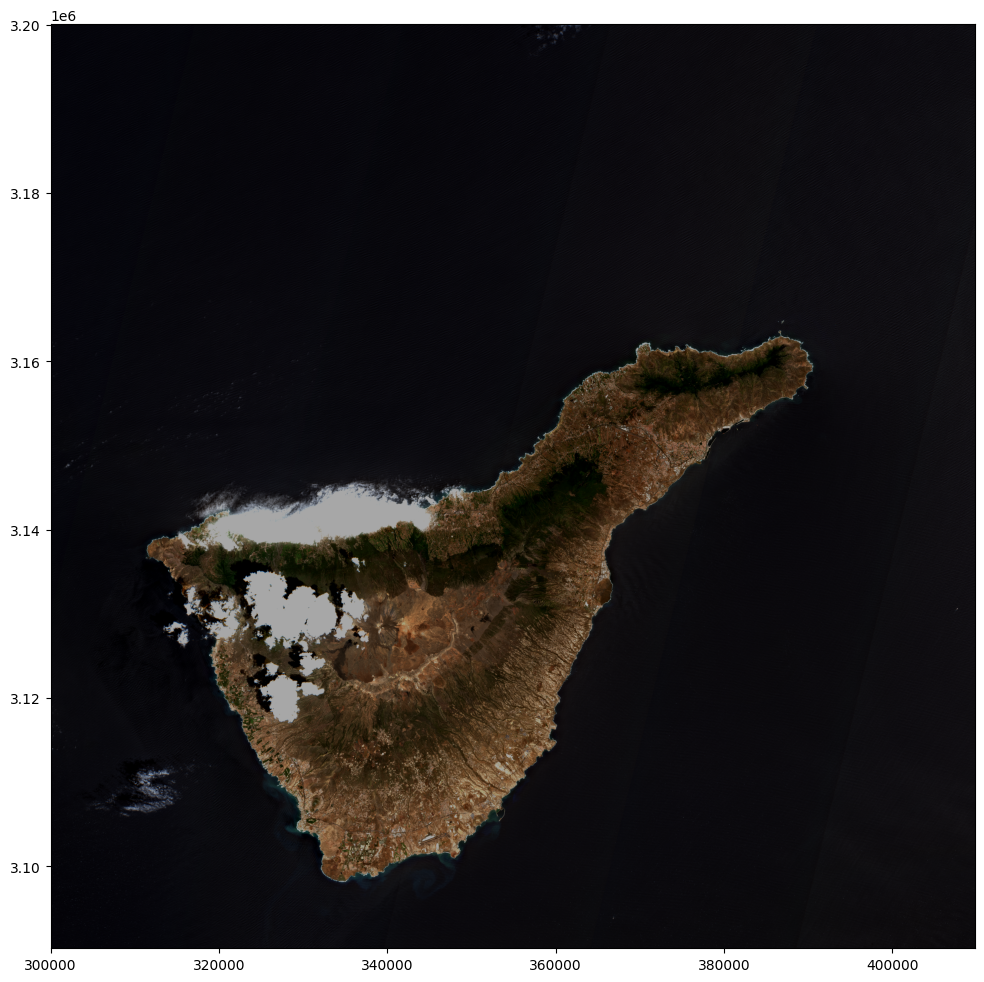

In [41]:
# Define a plot 2,98
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image.transpose(2,0,1), transform=img.transform);

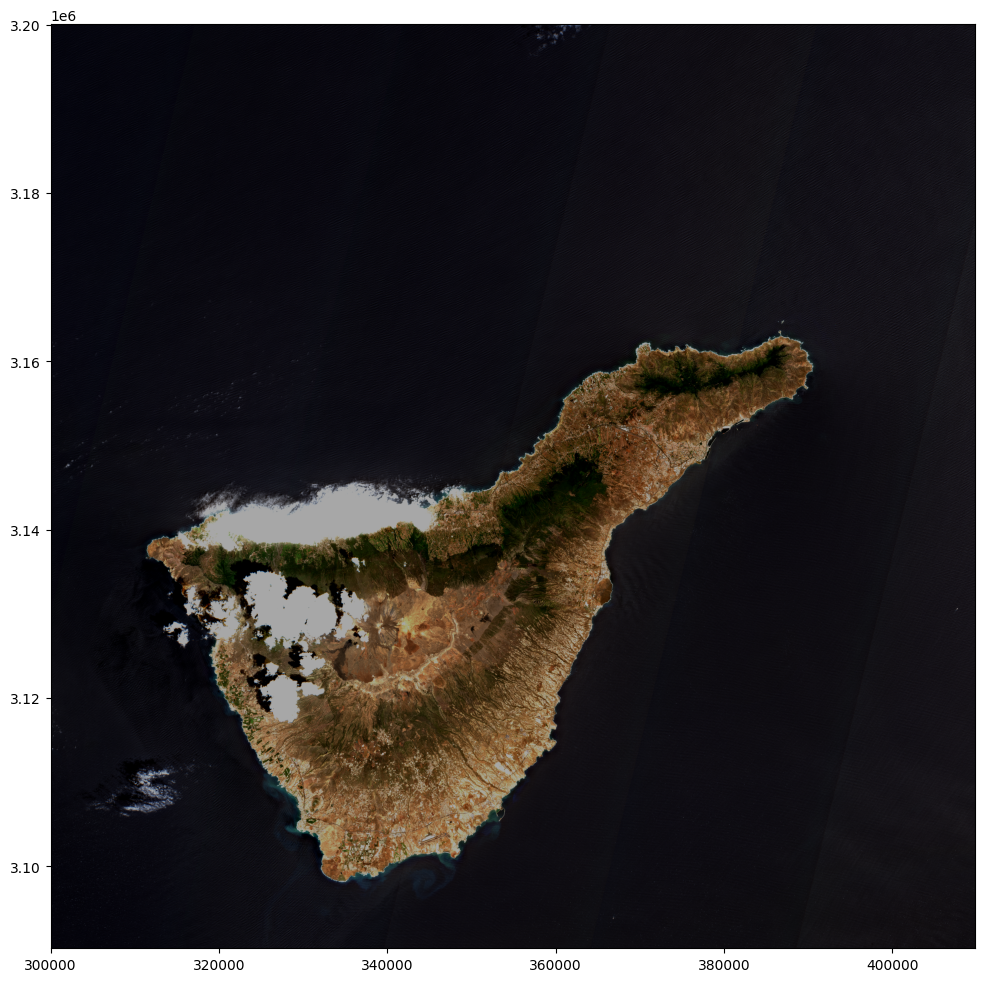

In [36]:
# Define a plot 3,97
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image.transpose(2,0,1), transform=img.transform);

In [30]:
# Define a plot 1,99
fig = plt.figure(figsize=(20,12))

# Show the figure
show(image.transpose(2,0,1), transform=img.transform);